In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, prange

In [8]:
@njit
def simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, x0 = 0, y0 = 0, eta0 = 0):
    x = np.zeros(Nsteps, dtype=np.float64)
    y = np.zeros(Nsteps, dtype=np.float64)
    eta = np.zeros(Nsteps, dtype=np.float64)

    tau_y = theta_y * tau_x
    tau_eta = theta_eta * tau_x
    sqtau_x = np.sqrt(dt/tau_x)
    sqtau_y = np.sqrt(dt/tau_y)
    sqtau_eta = np.sqrt(dt/tau_eta)

    x[0] = x0
    y[0] = y0
    eta[0] = eta0


    for t in range(Nsteps-1):
        y[t + 1] = y[t] + dt * (-y[t] + a * x[t])/tau_y + np.random.randn() * sqtau_y
        x[t + 1] = x[t] + dt * (-x[t] + sigma * eta[t])/tau_x + np.random.randn() * sqtau_x
        eta[t + 1] = eta[t] + dt * (-eta[t])/tau_eta + np.random.randn() * sqtau_eta
        
        
    return x, y, eta

In [120]:
@njit
def cov_matrix(sigma, theta_eta, a):
    theta = 1 + theta_eta
    offdiag = 1/2*a*(1 + theta_eta*sigma**2*(1+2*theta_eta)/theta**2)
    return np.array([[1 + theta_eta*sigma**2/theta,
                      offdiag],
                     [offdiag,
                      1 + a*offdiag]])

@njit
def probability_xy(x, y, det, cov_inv):
    return np.exp(-0.5 * (x**2 * cov_inv[0,0] + y**2 * cov_inv[1,1] + 2*x*y*cov_inv[0,1])) / (2*np.pi*np.sqrt(det))

@njit
def probability_x(x, cov):
    return np.exp(-0.5 * (x**2 / cov[0,0])) / (np.sqrt(2*np.pi*cov[0,0]))

@njit
def probability_y(y, cov):
    return np.exp(-0.5 * (y**2 / cov[1,1])) / (np.sqrt(2*np.pi*cov[1,1]))

@njit
def find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)


    mutual_trajectory = np.zeros(Nsteps, dtype=np.float64)

    for t in range(Nsteps):
        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        mutual_trajectory[t] = np.log(pjoint_curr / (px_curr * py_curr))

    return mutual_trajectory, x, y

@njit
def find_Axy(sigma, theta_eta, a):
    theta = 1 + theta_eta

    den = (4 + a**2)*theta**4 + 2*(2+a**2)*theta_eta*theta**3*sigma**2
    den += a**2*theta_eta**2*(theta + theta_eta)*sigma**4

    num1 = 4*theta**4 + a**2*(theta**4 + 2*(theta_eta + theta_eta**2)**2*sigma**2 - theta_eta**2*(theta + theta_eta)*sigma**4)
    num2 = 2*a*theta_eta*theta*sigma**2*(-1+theta_eta**2-theta_eta*sigma**2)

    return np.array([[num1/den, - num2/den],
                     [- a, 1]])

@njit
def find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    Amat = find_Axy(sigma, theta_eta, a)

    Sx_traj = np.zeros(Nsteps - 1, dtype = np.float64)
    Sy_traj = np.zeros(Nsteps - 1, dtype = np.float64)

    for t in range(Nsteps-1):
        Deltax = x[t+1] - x[t]
        Deltay = y[t+1] - y[t]
        Stratx = 1/2*(x[t+1] + x[t])
        Straty = 1/2*(y[t+1] + y[t])
        Sx_traj[t] = (-Amat[0,0]*Stratx - Amat[0,1]*Straty)*Deltax/dt
        Sy_traj[t] = (-Amat[1,0]*Stratx - Amat[1,1]*Straty)*Deltay/dt

        # Sx_traj[t], Sy_traj[t] = -np.dot(Amat, 1/2*np.array([x[t] + x[t+1] , y[t] + y[t+1]]))*np.array([x[t+1] - x[t] , y[t+1] - y[t]])

    return Sx_traj, Sy_traj

@njit
def find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0, y0, eta0, tau_x = 1, theta_y = 1):
    x, y, eta = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0, y0, eta0)

    Amat = find_Axy(sigma, theta_eta, a)
    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)

    Sxy = 0.
    Ixy = 0.

    for t in range(Nsteps-1):
        Delta_x = x[t+1] - x[t]
        Delta_y = y[t+1] - y[t]
        Strat_x = 1/2*(x[t+1] + x[t])
        Strat_y = 1/2*(y[t+1] + y[t])

        Sxy += -2*(Amat[0,0]*Strat_x + Amat[0,1]*Strat_y)*Delta_x/dt
        Sxy += -2*(Amat[1,0]*Strat_x + Amat[1,1]*Strat_y)*Delta_y/dt

        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        Ixy += np.log(pjoint_curr / (px_curr * py_curr))

    return -(1 - Lambda)*Sxy/(Nsteps - 1) + Lambda*Ixy/(Nsteps - 1), x[-1], y[-1], eta[-1]

In [148]:
@njit
def adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.01,
                      a_init = 0., tau_x = 1, theta_y = 1, Nburn = 100000):
    
    x0_burn, y0_burn, eta0_burn = simulate_xyeta(Nburn, dt, sigma, a_init, theta_eta, tau_x, theta_y)
    x0 = x0_burn[-1]
    y0 = y0_burn[-1]
    eta0 = eta0_burn[-1]

    x0_burn = None
    y0_burn = None
    eta0_burn = None

    L_adapt = np.zeros(Nadapt, dtype = np.float64)
    a_adapt = np.zeros(Nadapt, dtype = np.float64)
    L_adapt[0] = 0.
    a_adapt[0] = a_init

    for idx_adapt in range(1, Nadapt):
        a_bar = a_adapt[idx_adapt - 1] + delta_a * np.random.randn()
        L_bar, x0, y0, eta0 = find_functional(Nsteps, dt, sigma, a_bar, theta_eta, Lambda, x0, y0, eta0, tau_x, theta_y)

        if L_bar > L_adapt[idx_adapt - 1]:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        elif np.random.rand() < p_acc:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        else:
            a_adapt[idx_adapt] = a_adapt[idx_adapt - 1]
            L_adapt[idx_adapt] = L_adapt[idx_adapt - 1]

    return a_adapt, L_adapt

In [182]:
%%time

Nsteps = int(1e5)
Nadapt = 5000
sigma = 1.7
theta_eta = 1.2
delta_a = 0.05

Lambda = 0.9

dt = 1e-3

a_adapt, L_adapt = adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.00)
a_adapt = abs(a_adapt)

CPU times: user 29.3 s, sys: 396 ms, total: 29.7 s
Wall time: 30.2 s


0.8729501753128484


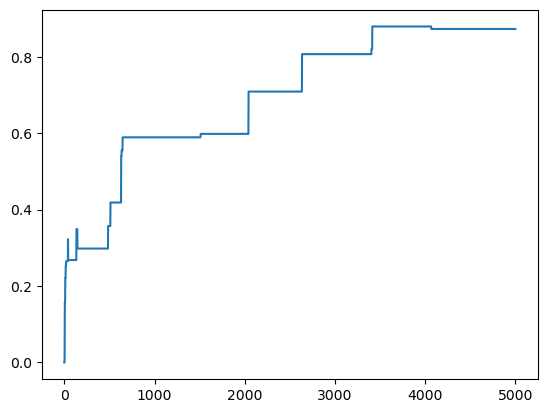

In [183]:
plt.plot(a_adapt)
print(a_adapt[-1])

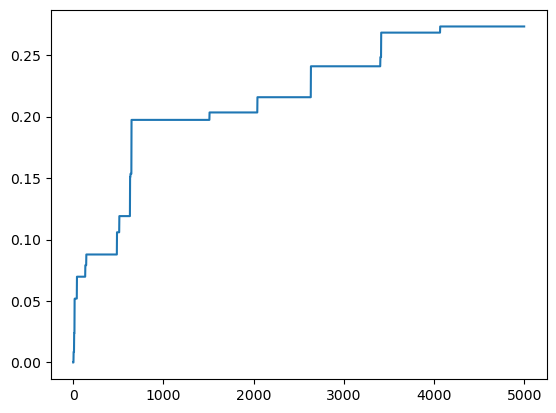

In [184]:
plt.plot(L_adapt)

In [110]:
Nsteps = int(5e5)
sigma = 0.63
theta_eta = 3.2
a = 9.6

Lambda = 0.9

dt = 1e-3

find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0 = 0., y0 = 0., eta0 = 0., tau_x = 1, theta_y = 1)

-4.466689688205942

In [111]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 3.2
a = 9.6
dt = 1e-3
Sx_traj, Sy_traj = find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [100]:
Sx_traj.mean(), Sy_traj.mean()

(-0.043062922122522655, 24.687403456573062)

In [84]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 1.2
a = 13.1
dt = 1e-4

MI_traj, xMI, yMI = find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [85]:
MI_traj.mean()

0.39543734152677096

In [74]:
find_Axy(sigma, theta_eta, a)

array([[ 8.20845124e-01,  1.65803590e-04],
       [-1.31000000e+01,  1.00000000e+00]])